In [1]:
# Implements the Doubly robust value estimator for the learned policies

In [87]:
import pandas as pd
import numpy as np
import pickle
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

In [88]:
df_train = pd.read_csv('../data/rl_train_data_final_cont_withC4_k.csv')

In [89]:
df_val = pd.read_csv('../data/rl_val_data_final_cont_withC4_k.csv')

In [166]:
df_test = pd.read_csv('../data/rl_test_data_final_cont.csv')

In [91]:
# load in the policies for the physician on val and test sets
phys_policy_val = pickle.load(open("val_policy.p", "rb" ))
phys_policy_test = pickle.load(open("test_policy.p", "rb" ))
phys_policy_test_KNN = pickle.load(open("test_policy_KNN.p", "rb" ))

In [92]:
# get the indices for indexing into the policy matrix. 
indices = phys_policy_test[:,4].astype(int) + 5
phys_action_probs = phys_policy_test[range(len(phys_policy_test)),indices]

In [93]:
# Two cells below - load the actions and q values associated with the agent policy - these are outputted by the
# neural network used to learn the optimal policy and eval_policy respectively.

In [150]:
agent_actions = pickle.load(open('../continuous/dqn_normal_c4_k4444/dqn_normal_actions_test.p', "rb" ))

<AxesSubplot:>

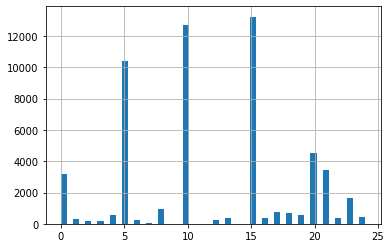

In [151]:
pd.Series(agent_actions).hist(bins=50)

In [152]:
agent_qsa = pickle.load(open('../continuous/dqn_normal_c4_k4444/dqn_normal_Qsa_test.p', "rb" ))
agent_qsa = np.array(agent_qsa)
Pi_e = softmax(agent_qsa,axis=1)
# phys_qsa = pickle.load(open('../continuous/phys_sarsa/phys_qsa_test.p', "rb" ))
# phys_qsa = np.array(phys_qsa)

In [153]:
Pi_e.shape

(55506, 25)

In [154]:
np.nansum(agent_qsa[2] * Pi_e[2])

10.22781

In [155]:
agent_q = pickle.load(open('../continuous/dqn_normal_c4_k4444/dqn_normal_q_test.p', "rb" ))

<AxesSubplot:>

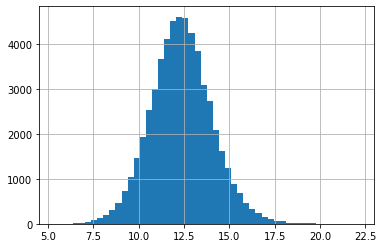

In [156]:
pd.Series(agent_q).hist(bins=50)

In [157]:
# add the actions and q values associated with agent performance on the test set to the dataframe

In [158]:
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [159]:
unique_ids = df_test['icustayid'].unique()

In [160]:
gamma = 0.99
Pi_b = phys_policy_test_KNN 
#Pi_b = phys_policy_test[:,5:30] 

def DR_estimator(Pi_e,Pi_b,Q_agent,df_test):
    rho_all = []
    DR =[]
    V_WDR = 0
    ind = 0
    for uid in unique_ids:
        rho = []
        traj = df_test.loc[df_test['icustayid'] == uid]
        for t in range(len(traj)):
            iv = df_test.loc[ind,'iv_input']
            vaso = df_test.loc[ind, 'vaso_input']
            phys_action = action_map[(iv,vaso)]    #行为策略 a
            if np.isclose(Pi_b[ind][phys_action], 0.0): 
                rho_t = Pi_e[ind][phys_action] / 0.001
            else:
                rho_t = Pi_e[ind][phys_action] / Pi_b[ind][phys_action]  #df_test['phys_prob'][ind]   #使用的是数据行为动作            
            rho.append(rho_t)
            ind +=1
        rho_all.append(np.array(rho))
    max_H = max(len(rho) for rho in rho_all)
    rho_cum = np.zeros((len(unique_ids), max_H))
    for i, rho in enumerate(rho_all):
        rho_tmp = np.ones(max_H)
        rho_tmp[:len(rho)] = rho
        rho_cum[i] = np.cumprod(rho_tmp)
    ind = 0
    n_traj = 0
    for uid in unique_ids:
        trajectory = df_test.loc[df_test['icustayid'] == uid]    
        rho_cumulative = rho_cum[n_traj]
        V_WDR = 0
        for t in range(len(trajectory)):
            iv = df_test.loc[ind,'iv_input']
            vaso = df_test.loc[ind, 'vaso_input']
            phys_action = action_map[(iv,vaso)]   #行为策略 a
            Q_hat =  Q_agent[ind][phys_action]   #   test_set <s,a,r>
            #V_hat = Q_agent[ind].max()
            V_hat = np.nansum(Q_agent[ind] * Pi_e[ind])
            r_t = df_test['reward'][ind]
            rho_1t = rho_cumulative[t]
            if t == 0:
                rho_1t_1 = 1.0
            else:
                rho_1t_1 = rho_cumulative[t-1]
            V_WDR = V_WDR + np.power(gamma, t) * (rho_1t * r_t - (rho_1t * Q_hat - rho_1t_1 * V_hat))
            #print(V_WDR)
            ind+=1
        DR.append(V_WDR)
        n_traj +=1
    return DR

In [161]:
DR = DR_estimator(Pi_e,Pi_b,agent_qsa,df_test)
np.nanmean(np.clip(DR, -15, 15))

11.034645246439066

In [164]:
gamma = 0.99
Pi_b = phys_policy_test_KNN 
#Pi_b = phys_policy_test[:,5:30] 
def WDR_estimator(Pi_e,Pi_b,Q_agent,df_test):
    rho_all = []
    DR =[]
    V_WDR = 0
    ind = 0
    for uid in unique_ids:
        rho = []
        traj = df_test.loc[df_test['icustayid'] == uid]
        for t in range(len(traj)):
            iv = df_test.loc[ind,'iv_input']
            vaso = df_test.loc[ind, 'vaso_input']
            phys_action = action_map[(iv,vaso)]    #行为策略 a
            #agent_a = df_test['agent_action'][ind]
            
            if np.isclose(Pi_b[ind][phys_action], 0.0): 
                rho_t = Pi_e[ind][phys_action] / 0.001
            else:
                rho_t = Pi_e[ind][phys_action] / Pi_b[ind][phys_action]  #df_test['phys_prob'][ind]   #使用的是数据行为动作
            rho.append(rho_t)
            ind +=1
        rho_all.append(np.array(rho))
    max_H = max(len(rho) for rho in rho_all)
    rho_cum = np.zeros((len(unique_ids), max_H))
    for i, rho in enumerate(rho_all):
        rho_tmp = np.ones(max_H)
        rho_tmp[:len(rho)] = rho
        rho_cum[i] = np.cumprod(rho_tmp)   #累乘（uids，H）
    weights = np.mean(rho_cum,axis=0)
    print(weights)
    ind = 0
    n_traj = 0
    for uid in unique_ids:
        trajectory = df_test.loc[df_test['icustayid'] == uid]    
        rho_cumulative = rho_cum[n_traj]
        V_WDR = 0
        for t in range(len(trajectory)):
            iv = df_test.loc[ind,'iv_input']
            vaso = df_test.loc[ind, 'vaso_input']
            phys_action = action_map[(iv,vaso)]   #行为策略 a
            Q_hat =  Q_agent[ind][phys_action]   #   test_set <s,a,r>
            V_hat = np.nansum(Q_agent[ind] * Pi_e[ind])
            #V_hat = Q_agent[ind].max()
            r_t = df_test['reward'][ind]
            rho_1t = rho_cumulative[t]/weights[t]
            if t == 0:
                rho_1t_1 = 1.0
            else:
                rho_1t_1 = rho_cumulative[t-1]/weights[t-1]
            V_WDR = V_WDR + np.power(gamma, t) * (rho_1t * r_t - (rho_1t * Q_hat - rho_1t_1 * V_hat))
            #print(V_WDR)
            ind+=1
        DR.append(V_WDR)
        n_traj +=1
    return DR

In [165]:
WDR = WDR_estimator(Pi_e,Pi_b,agent_qsa,df_test)
np.mean(np.clip(WDR, -15, 15))

[5.91249341e-01 2.57311643e+00 1.03790110e+02 9.12595618e+00
 5.81638896e+01 4.00438216e+02 4.56364208e+03 5.47490359e+02
 1.79820922e+02 2.91118448e+02 1.11918193e+03 2.30248406e+03
 6.12577474e+03 1.55512643e+04 1.70287340e+04 3.97827027e+04
 2.21727172e+04 2.18888306e+04 2.98745139e+04 5.01274995e+04]


11.243053242216256

In [167]:
# Evaluate the average return under the physician policy on the test set.
phys_vals = []
gamma = 0.99
for uid in unique_ids:
    traj = df_test.loc[df_test['icustayid'] == uid]
    ret = 0
    reversed_traj = traj.iloc[::-1]
    for row in reversed_traj.index:
        ret = reversed_traj.loc[row,'reward'] + gamma*ret
    phys_vals.append(ret)
np.mean(phys_vals)

9.96289026695225